# Introduction to sqlite and SQL  

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from pandas.io import sql
import sqlite3

/Users/michaeltwardos/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
conn = sqlite3.connect('eliflo.db', detect_types=sqlite3.PARSE_DECLTYPES)

### Setup

In [4]:
#The data has information about when eliflo users signed up and other metadata about them.
data = pd.read_csv('eliflo_users.csv', low_memory=False)
data.head()

,customerid,datecreated,source,mailinglist,testgroup,orgid,parentid
0,1,1398138810,GUEST_INVITE,1,0,11,10803
1,2,1384487104,ORG_INVITE,0,0,1,316
2,3,1363734892,ORG_INVITE,0,0,94,1525
3,4,1369123768,GUEST_INVITE,0,0,1,5151
4,5,1358417660,GUEST_INVITE,0,0,193,5240


In [5]:
#Put data into the eliflo DB
data.to_sql('eliflo_users',
            con=conn,
            if_exists='replace',
            index=False)

### Count, Sum, Average

In [6]:
#Our first query in python sqlite!  What does * mean?
#Who knows the HelloWorld of SQL?
a=sql.read_sql('''
select * from eliflo_users
limit 3;
''', con=conn)
a
#Question - Given a new data set in SQL, what are ways you start categorizing a data set?  
#What is the equivalent of df.describe?

,customerid,datecreated,source,mailinglist,testgroup,orgid,parentid
0,1,1398138810,GUEST_INVITE,1,0,11,10803
1,2,1384487104,ORG_INVITE,0,0,1,316
2,3,1363734892,ORG_INVITE,0,0,94,1525


In [7]:
#See what tables currently exist in your database.
a=sql.read_sql('''
SELECT name FROM sqlite_master WHERE type = "table";
''', con=conn)
a

,name
0,eliflo_activity
1,eliflo_master_fact
2,eliflo_users


In [8]:
#Examples of count, sum and average functions
a=sql.read_sql('''
select  
    count(*)  as num_of_rows,
    count(distinct(customerid))  as distinct_customers,
    sum(mailinglist) as num_mailing,
    avg(mailinglist) as mailing_probability
from 
    eliflo_users ;
''', con=conn)
a

,num_of_rows,distinct_customers,num_mailing,mailing_probability
0,12000,12000,2994,0.2495


How many distinct users (parentid) invited a customer?

In [10]:
a=sql.read_sql('''
select  
    count(distinct(parentid))  as distinct_customers
from 
    eliflo_users ;
''', con=conn)
a

,distinct_customers
0,2565


### Min, Max

In [8]:
#use min, max and date to compute date range.
#Date functionality is very useful.
a=sql.read_sql('''
select  
    date(min(datecreated), 'unixepoch') as start_date, 
    date(max(datecreated), 'unixepoch') as end_date
from 
    eliflo_users ;
''', con=conn)
a

,start_date,end_date
0,2012-05-31,2014-05-30


### Case

In [ ]:
#Example of using case 
a=sql.read_sql('''
select  
    sum(case when mailinglist = 1 then 1 else 0 end) as mailing_true,
    sum(case when mailinglist = 0 then 1 else 0 end) as mailing_false 
from 
    eliflo_users ;
''', con=conn)
a

Use case to measure how many customers were invited by someone

In [ ]:
#Example of using case 
a=sql.read_sql('''
select  
    sum(case when invitedby > 0 then 1 else 0 end) as invited
from 
    eliflo_users ;
''', con=conn)
a

# Equivalently

a=sql.read_sql('''
select  
    count(distinct(customerid))
from 
    eliflo_users 
where
    invitedby > 0;
''', con=conn)
a

### Group By

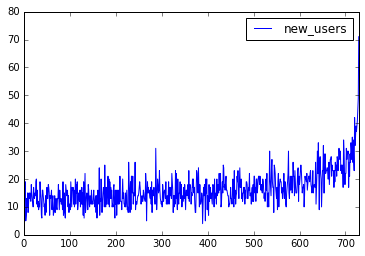

In [11]:
#Show signups per day
a=sql.read_sql('''
select 
    date(datecreated, 'unixepoch') as day_created, 
    count(*) as new_users 
from 
    eliflo_users 
group by 1
''', con=conn)
a.plot()

How many users came through each source?

In [12]:
#What are the most popular sources that users came from?
a=sql.read_sql('''
select 
    source, 
    count(*) as new_users 
from 
    eliflo_users 
group by 1 
order by 2 desc;
''', con=conn)
a

,source,new_users
0,ORG_INVITE,4254
1,GUEST_INVITE,2163
2,PERSONAL_PROJECTS,2111
3,SIGNUP,2087
4,SIGNUP_GOOGLE_AUTH,1385


### Modulo

In [13]:
#Bucketing users.  Good for experiments!
a=sql.read_sql('''
select 
    customerid % 4, 
    count(*) as new_users 
from 
    eliflo_users 
group by 1
''', con=conn)
a

,customerid % 4,new_users
0,0,3000
1,1,3000
2,2,3000
3,3,3000


# Master Fact activity data and growth measurements

In [ ]:
#Get data about these users subsequent activity
activity = pd.read_csv('eliflo_activity.csv', low_memory=False)
activity.head()

In [ ]:
#Convert activity to sqlite
activity.to_sql('eliflo_master_fact',
            con=conn,
            if_exists='replace',
            index=False)

### Subquery

In [ ]:
#Example of a subquery
a=sql.read_sql('''
select
visits,
count(distinct(customerid)) as customers
from
(
select
    customerid,
    count(*) as visits
from
    eliflo_master_fact
where
    eventtype = 'login'
group by 1 
) q
group by 1 
order by 2 desc;
    ''', con=conn)
a.head(5)
               

### Join Example

In [ ]:
Give me the users that were active one day that were also active another day.

In [ ]:
#This query show the percentage of customers per cohort that were active in the second week after they signed up.
a=sql.read_sql('''
select
    count(distinct(b.customerid)) as returning_users
from
    eliflo_master_fact a
left join
    eliflo_master_fact b
on
    a.customerid = b.customerid
where
    substr(date(a.timestamp, 'unixepoch'), 1,10)='2014-01-01' and
    substr(date(b.timestamp, 'unixepoch'), 1,10)='2014-01-07'
    ''', con=conn)
a.head(10)

# Measuring the Retention Rate and Other Susceptibilities

In [ ]:
#This query show the percentage of customers per cohort that were active in the second week after they signed up.
a=sql.read_sql('''
select 
    a.day_created,
    cast(returning_users as real)/new_users
from
(
select
    substr(date(datecreated, 'unixepoch'), 1,7) as day_created,
    count(distinct(customerid)) as new_users
from
    eliflo_users 
group by 1
) a
left join
(
select
    substr(date(a.datecreated, 'unixepoch'), 1,7) as day_created,
    count(distinct(b.customerid)) as returning_users
from
    eliflo_users a
left join
    eliflo_activity b
on
    a.customerid = b.customerid
where
    b.timestamp between a.datecreated + 7*86400 and a.datecreated + 14*86400
group by 1
) b
on a.day_created = b.day_created
    ''', con=conn)
a.head(10)

In [ ]:
#This query looks at the retention rate for a selected cohort.
a=sql.read_sql('''
select 
    month as age_in_months,
    cast(returning_users as real)/initial_cohort as retention_rate
from
(select
   cast((b.timestamp - a.datecreated)/(86400*30) as int) as month,
    count(distinct(b.customerid)) as returning_users
from
    eliflo_users a
left join
    eliflo_activity b
on
    a.customerid = b.customerid
where
    substr(date(a.datecreated, 'unixepoch'), 1,7) = '2012-06' and
    cast((b.timestamp - a.datecreated)/(86400*30) as int) >= 0
group by 1) a,
(select
    count(distinct(customerid)) as initial_cohort
from
    eliflo_users a
where
    substr(date(a.datecreated, 'unixepoch'), 1,7) = '2012-06' 
)
    ''', con=conn)
a.head(100)

In [ ]:
#Generalizing the calculation of a retention curve
def constructRetentionCurve(month):
    string = '''
    select 
        month,
        cast(returning_users as real)/initial_cohort as retention_Rate
    from
    (select
        cast((b.timestamp - a.datecreated)/(86400*30) as int) as month,
        count(distinct(b.customerid)) as returning_users
    from
        eliflo_users a
    left join
        eliflo_activity b
    on
        a.customerid = b.customerid
    where
        substr(date(a.datecreated, 'unixepoch'), 1,7) = '%s' and
        cast((b.timestamp - a.datecreated)/(86400*30) as int) >= 0
    group by 1) a,
    (select
        count(distinct(customerid)) as initial_cohort
    from
        eliflo_users a
    where
        substr(date(a.datecreated, 'unixepoch'), 1,7) = '%s'  
    )
    ''' % (month, month)
    return string

In [ ]:
a=sql.read_sql(constructRetentionCurve('2012-10'), con=conn)
b=sql.read_sql(constructRetentionCurve('2012-06'), con=conn)
#How do we join the retention curves together?